##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!ls

gdrive	sample_data


####  <font color=SlateBlue>CNN</font> ####

In [3]:
import torch
import torch.optim as optim
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

##  <font color=MediumSlateBlue>Classes and Functions</font> ##

####  <font color=SlateBlue>Transfer Sub-Net Encoder Module</font> ####

In [4]:
class TransferSubNetEncoder(nn.Module):
  def __init__(self, requires_grad=False):
    super(TransferSubNetEncoder, self).__init__()

    vgg = self.modifyVGG()

    vgg_layers = list(vgg.children())
    self.slice1 = nn.Sequential(*vgg_layers[0:6])  
    self.slice2 = nn.Sequential(*vgg_layers[6:13])  
    self.slice3 = nn.Sequential(*vgg_layers[13:26])  
    self.slice4 = nn.Sequential(*vgg_layers[26:30])  

  def modifyVGG(self):
    vgg = models.vgg19_bn(pretrained=True, progress=False).features

    # Freeze all VGG parameters since we’re only optimizing the target image
    for param in vgg.parameters():
      param.requires_grad_(False)

    for i, layer in vgg.named_children():
      if isinstance(layer, torch.nn.MaxPool2d):
        vgg[int(i)] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

    return vgg

  def forward(self, input):
    out1 = self.slice1(input)
    out2 = self.slice2(out1)
    out3 = self.slice3(out2)
    out4 = self.slice4(out3)
    return {'Slice1':out1, 'Slice2':out2, 'Slice3':out3, 'Encoder':out4}


####  <font color=SlateBlue>Transfer Sub-Net Decoder Module</font> ####

In [5]:
class ConvBachNormReLU(nn.Module):
  def __init__(self, in_channels_size, out_channels_size, 
               kernel_size=(3, 3), stride_size=(1, 1), padding_size=(1, 1)):
    super(ConvBachNormReLU, self).__init__()

    conv_layer = nn.Conv2d(in_channels=in_channels_size,
                           out_channels=out_channels_size,
                           kernel_size=kernel_size,
                           stride=stride_size,
                           padding=padding_size)
    
    bn_layer = nn.BatchNorm2d(out_channels_size, 
                              eps=1e-05, 
                              momentum=0.1, 
                              affine=True, 
                              track_running_stats=True)

    activation_layer = nn.ReLU(inplace=True)

    self.unit = nn.Sequential(conv_layer, 
                              bn_layer, 
                              activation_layer)
      
  def forward(self, input): return self.unit(input)

In [6]:
class TransferSubNetDecoder(nn.Module):
  def __init__(self):
    super(TransferSubNetDecoder, self).__init__()

    self.slice_4 = nn.Sequential(ConvBachNormReLU(512, 256),
                                 nn.Upsample(scale_factor=2, mode='nearest'))
    
    self.slice_3 = nn.Sequential(ConvBachNormReLU(256, 256),
                                 ConvBachNormReLU(256, 256),
                                 ConvBachNormReLU(256, 256),
                                 ConvBachNormReLU(256, 128),
                                 nn.Upsample(scale_factor=2, mode='nearest'))
    
    self.slice_2 = nn.Sequential(ConvBachNormReLU(128, 128),
                                 ConvBachNormReLU(128, 64),
                                 nn.Upsample(scale_factor=2, mode='nearest'))
    
    self.slice_1 = nn.Sequential(ConvBachNormReLU(64, 64),
                                 ConvBachNormReLU(64, 3))

  def forward(self, encoder_outputs):
    out4 = self.slice_4(encoder_outputs['Encoder'])

    in3 = out4 + encoder_outputs['Slice3']
    out3 = self.slice_3(in3)

    in2 = out3 + encoder_outputs['Slice2']
    out2 = self.slice_2(in2)

    in1 = out2 + encoder_outputs['Slice1']
    return self.slice_1(in1)

####  <font color=SlateBlue>Transfer Sub-Net</font> ####

In [7]:
def calc_mean_std(features, eps=1e-5):
  # eps is a small value added to the variance to avoid divide-by-zero.
  size = features.size()
  assert (len(size) == 4)
  N, C = size[:2]

  features_var = features.view(N, C, -1).var(dim=2) + eps
  features_std = features_var.sqrt().view(N, C, 1, 1)

  features_mean = features.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)

  return features_mean, features_std

def AdaIN(content_features, style_features):
  assert (content_features.size()[:2] == style_features.size()[:2])
  size = content_features.size()

  style_mean, style_std = calc_mean_std(style_features)
  content_mean, content_std = calc_mean_std(content_features)

  normalized_features = (content_features - content_mean.expand(size)) / content_std.expand(size)

  return normalized_features * style_std.expand(size) + style_mean.expand(size)

In [8]:
class TransferSubNet(nn.Module):
  def __init__(self):
    super(TransferSubNet, self).__init__()

    self.encoder = TransferSubNetEncoder()
    self.decoder = TransferSubNetDecoder()

  def forward(self, R, T_prime):
    style_features = self.encoder(R)
    content_features = self.encoder(T_prime)

    decoder_in = AdaIN(content_features['Encoder'], style_features['Encoder'])
    
    #return self.decoder(decoder_in)
    return self.decoder({'Slice1':content_features['Slice1'], 'Slice2':content_features['Slice2'], 'Slice3':content_features['Slice3'], 'Encoder':decoder_in})



##  <font color=SlateBlue>Train Transfer Sub-Net</font> ##

###  <font color=SlateBlue>perceptual Loss </font> ###

In [9]:
class VGGLossNet(nn.Module):
  def __init__(self, requires_grad=False):
    super(VGGLossNet, self).__init__()

    vgg = self.modifyVGG()

    vgg_layers = list(vgg.children())
    self.conv1_1 = nn.Sequential(*vgg_layers[0:1])  
    self.conv2_1 = nn.Sequential(*vgg_layers[1:6])  
    self.conv3_1 = nn.Sequential(*vgg_layers[6:11])  
    self.conv4_1 = nn.Sequential(*vgg_layers[11:20]) 
    self.conv4_2 = nn.Sequential(*vgg_layers[20:22])
    self.conv5_1 = nn.Sequential(*vgg_layers[22:29])  

  def modifyVGG(self):
    vgg = models.vgg19(pretrained=True, progress=False).features

    # Freeze all VGG parameters since we’re only optimizing the target image
    for param in vgg.parameters():
      param.requires_grad_(False)
    return vgg

  def forward(self, input):
    conv1_1 = self.conv1_1(input)
    conv2_1 = self.conv2_1(conv1_1)
    conv3_1 = self.conv3_1(conv2_1)
    conv4_1 = self.conv4_1(conv3_1)
    conv4_2 = self.conv4_2(conv4_1)
    conv5_1 = self.conv5_1(conv4_2)
    return {'Conv1_1':conv1_1, 'Conv2_1':conv2_1, 'Conv3_1':conv3_1, 'Conv4_1':conv4_1, 'Conv4_2':conv4_2, 'Conv5_1':conv5_1}

In [10]:
class TransformerNetwork(nn.Module):
    """Feedforward Transformation Network without Tanh
    reference: https://arxiv.org/abs/1603.08155 
    exact architecture: https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf
    """
    def __init__(self):
        super(TransformerNetwork, self).__init__()
        self.ConvBlock = nn.Sequential(
            ConvLayer(3, 32, 9, 1),
            nn.ReLU(),
            ConvLayer(32, 64, 3, 2),
            nn.ReLU(),
            ConvLayer(64, 128, 3, 2),
            nn.ReLU()
        )
        self.ResidualBlock = nn.Sequential(
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3), 
            ResidualLayer(128, 3)
        )
        self.DeconvBlock = nn.Sequential(
            DeconvLayer(128, 64, 3, 2, 1),
            nn.ReLU(),
            DeconvLayer(64, 32, 3, 2, 1),
            nn.ReLU(),
            ConvLayer(32, 3, 9, 1, norm="None")
        )

    def forward(self, x):
        x = self.ConvBlock(x)
        x = self.ResidualBlock(x)
        out = self.DeconvBlock(x)
        return out


class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, norm="instance"):
        super(ConvLayer, self).__init__()
        # Padding Layers
        padding_size = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding_size)

        # Convolution Layer
        self.conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

        # Normalization Layers
        self.norm_type = norm
        if (norm=="instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif (norm=="batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.reflection_pad(x)
        x = self.conv_layer(x)
        if (self.norm_type=="None"):
            out = x
        else:
            out = self.norm_layer(x)
        return out

class ResidualLayer(nn.Module):
    """
    Deep Residual Learning for Image Recognition
    https://arxiv.org/abs/1512.03385
    """
    def __init__(self, channels=128, kernel_size=3):
        super(ResidualLayer, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size, stride=1)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, kernel_size, stride=1)

    def forward(self, x):
        identity = x                     # preserve residual
        out = self.relu(self.conv1(x))   # 1st conv layer + activation
        out = self.conv2(out)            # 2nd conv layer
        out = out + identity             # add residual
        return out

class DeconvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding, norm="instance"):
        super(DeconvLayer, self).__init__()

        # Transposed Convolution 
        padding_size = kernel_size // 2
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding_size, output_padding)

        # Normalization Layers
        self.norm_type = norm
        if (norm=="instance"):
            self.norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        elif (norm=="batch"):
            self.norm_layer = nn.BatchNorm2d(out_channels, affine=True)

    def forward(self, x):
        x = self.conv_transpose(x)
        if (self.norm_type=="None"):
            out = x
        else:
            out = self.norm_layer(x)
        return out

In [11]:
#https://pytorch.org/tutorials/advanced/neural_style_tutorial.html
#https://medium.com/udacity-pytorch-challengers/style-transfer-using-deep-nural-network-and-pytorch-3fae1c2dd73e

def gramMat(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

def calcStylLoss(targetFeatures, styleFeatures, styleWeights):
  loss = 0.0
  for layer in styleWeights:
    
    trgGram = gramMat(targetFeatures[layer])
    stylGram = gramMat(styleFeatures[layer])#.detach()

    loss += styleWeights[layer] * F.mse_loss(stylGram, trgGram)
  return loss



In [12]:
batch_size = 4
num_epochs = 30

In [13]:
%run /content/gdrive/MyDrive/Final_Proj_Deep/PrepData_Amir_TestNew.ipynb
trainDataCamvid = loadDataLoader(batch_size)

In [14]:
transNet = TransferSubNet().cuda()
lossNet = VGGLossNet().cuda()
optimizer = optim.Adam(transNet.parameters(), lr =0.001)
styleWeights = {'Conv1_1': 1.,
                 'Conv2_1': 0.75,
                 'Conv3_1': 0.2,
                 'Conv4_1': 0.2,
                 'Conv5_1': 0.2}

perceptualCoeff = 0.2
reconstCoeff = 0.8
contCoeff = 1
stylCoeff = 2.5*1e5

Epoch 1 has started......


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
No handles with labels found to put in legend.


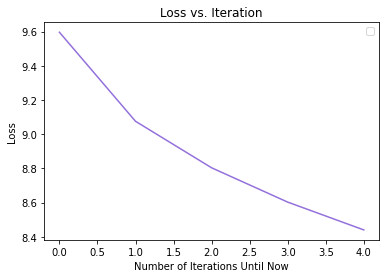

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


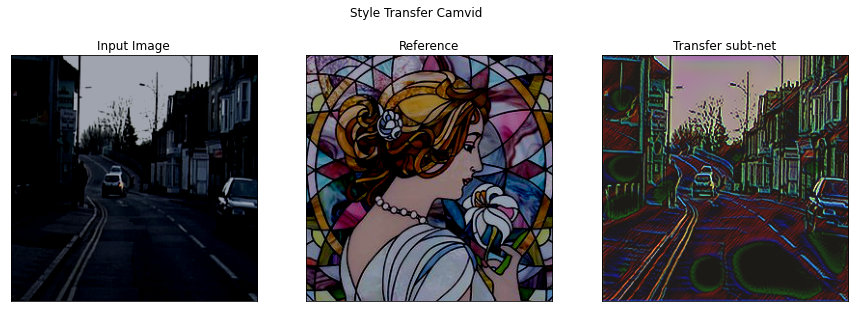

Epoch 2 has started......


No handles with labels found to put in legend.


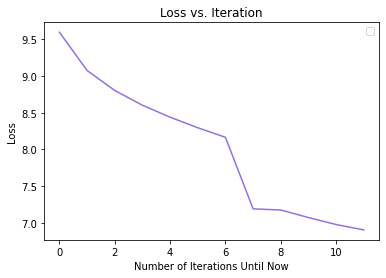

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


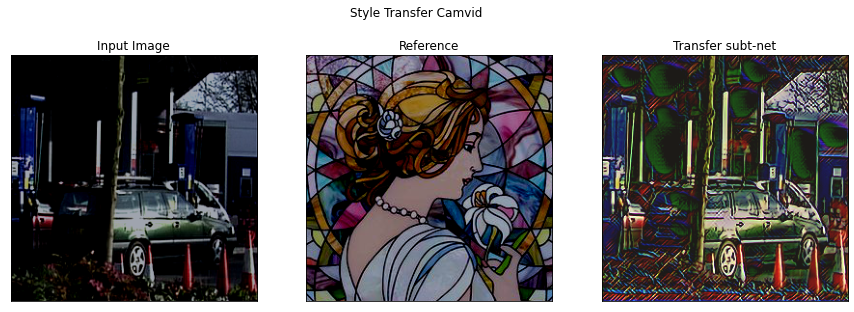

Epoch 3 has started......


No handles with labels found to put in legend.


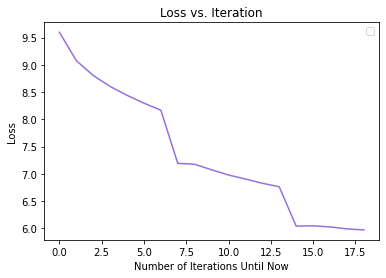

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


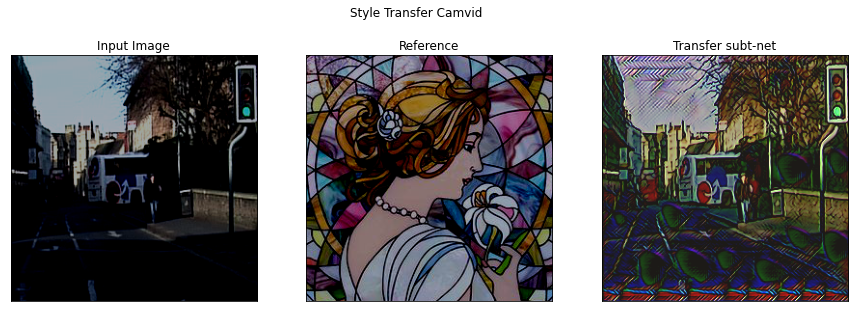

Epoch 4 has started......


No handles with labels found to put in legend.


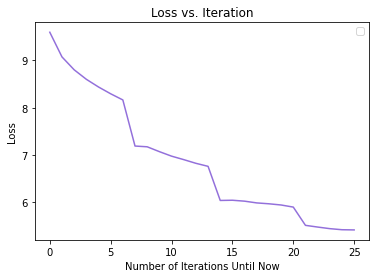

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


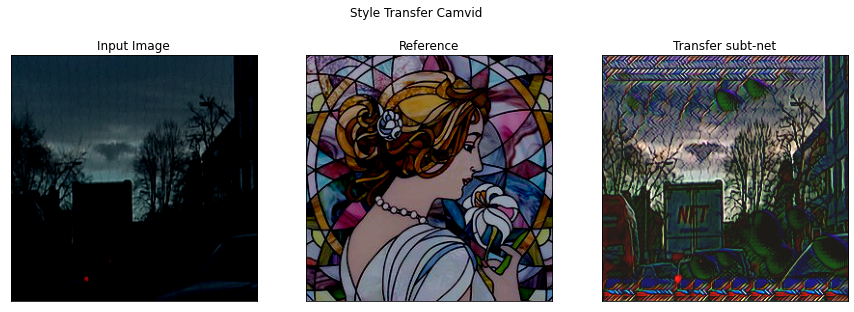

Epoch 5 has started......


No handles with labels found to put in legend.


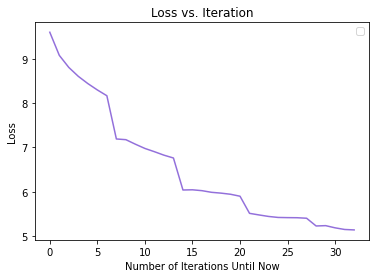

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


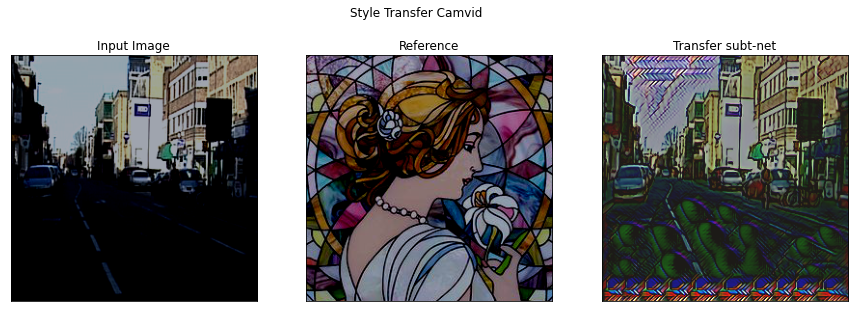

Epoch 6 has started......


No handles with labels found to put in legend.


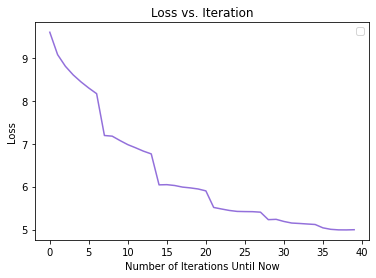

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


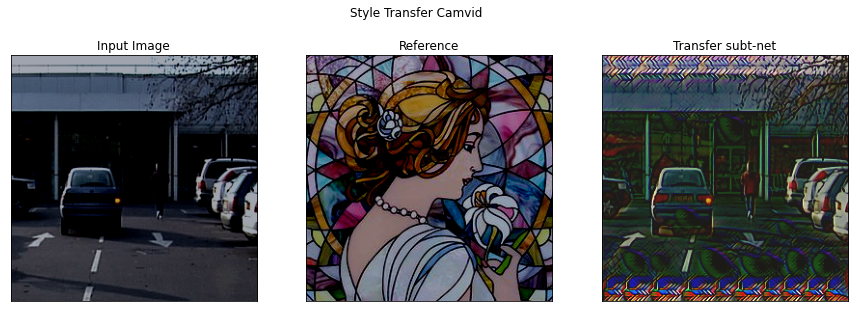

Epoch 7 has started......


No handles with labels found to put in legend.


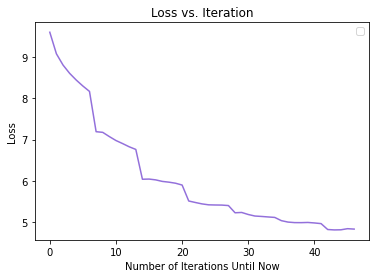

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


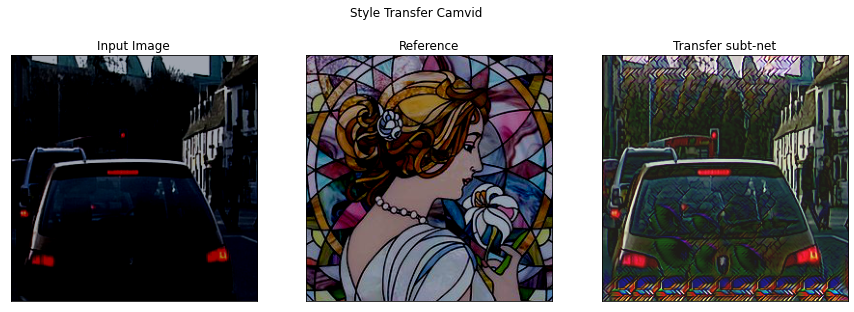

Epoch 8 has started......


No handles with labels found to put in legend.


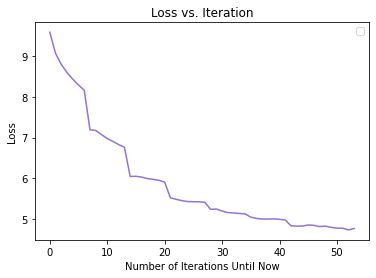

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


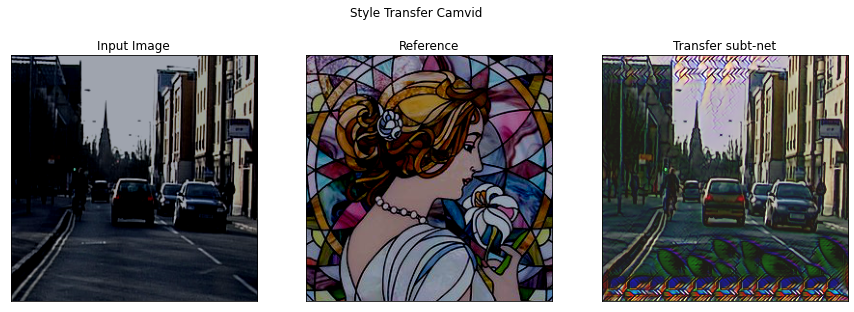

Epoch 9 has started......


No handles with labels found to put in legend.


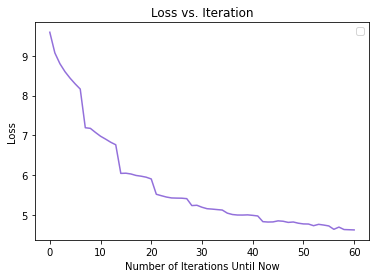

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


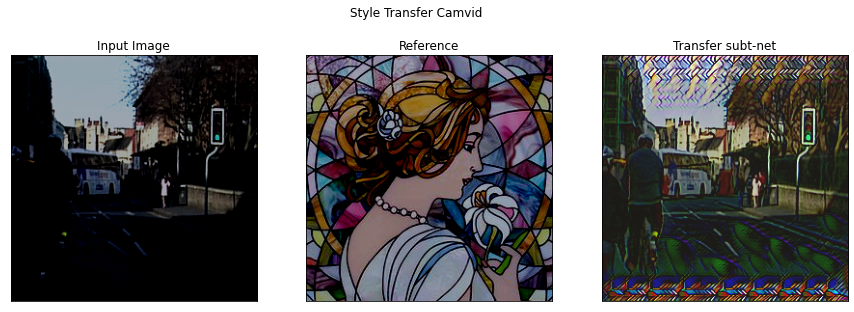

Epoch 10 has started......


No handles with labels found to put in legend.


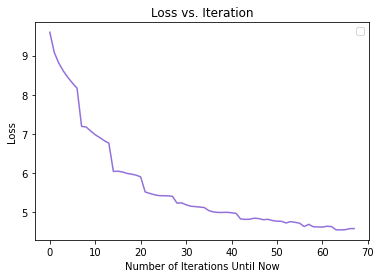

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


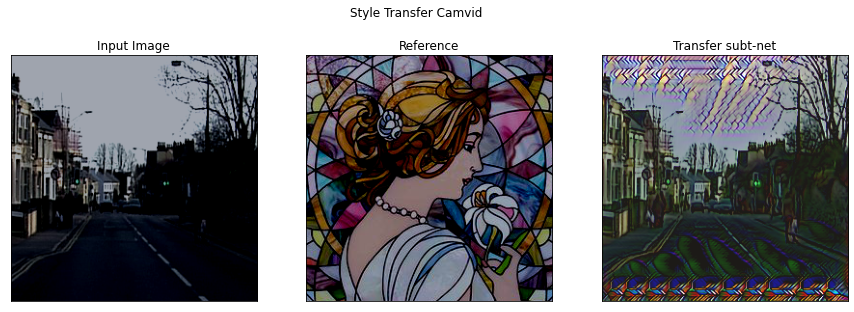

Epoch 11 has started......


No handles with labels found to put in legend.


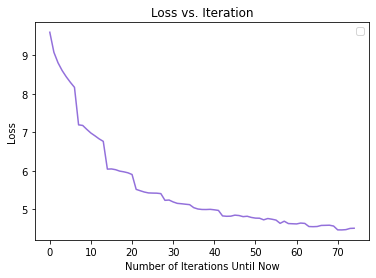

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


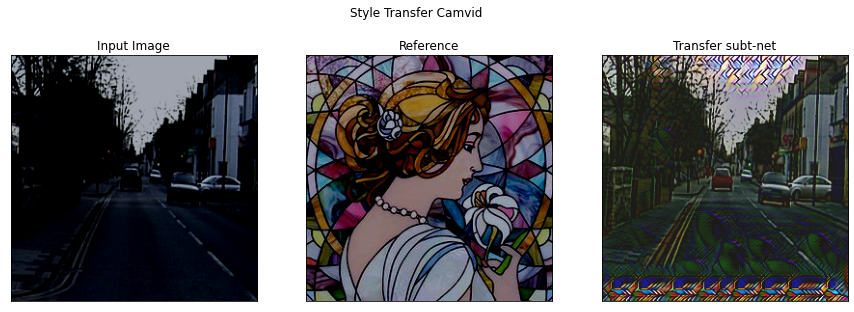

Epoch 12 has started......


No handles with labels found to put in legend.


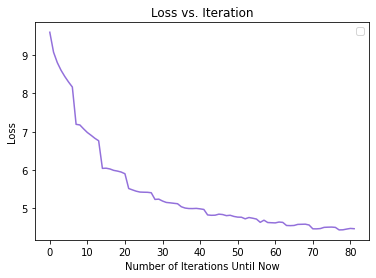

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


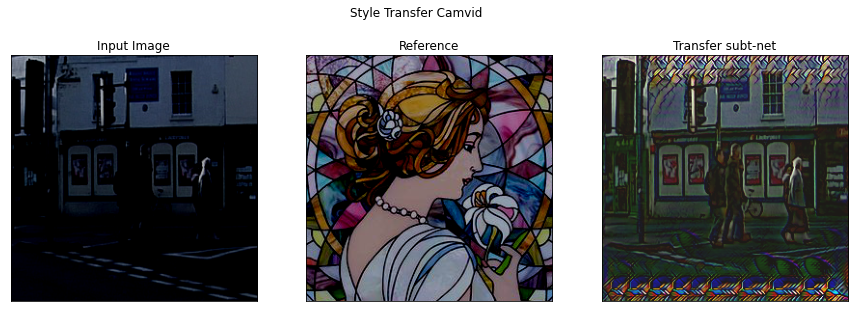

Epoch 13 has started......


In [ ]:
transNet.train()
losses = []
for epoch in range(num_epochs):
  print('Epoch %d has started......' %(epoch+1))
  iter_loss = 0
  
  for idx, (inputImg, refImg) in enumerate(trainDataCamvid):
    inputImg = Variable(inputImg).cuda()
    refImg  = Variable(refImg).cuda()
    
    content = inputImg
    style = refImg
    target = transNet(style, inputImg)

    contentFeatures = lossNet(content)
    styleFeatures = lossNet(style)
    targetFeatures = lossNet(target)

    contentLoss = torch.mean((contentFeatures['Conv4_2'] - targetFeatures['Conv4_2'])**2)
    stylLoss = calcStylLoss(targetFeatures, styleFeatures, styleWeights)
    reconstLoss =  F.mse_loss(target, content)

    totalLoss = perceptualCoeff*(contCoeff * contentLoss + stylCoeff * stylLoss) + reconstCoeff * reconstLoss
    iter_loss += totalLoss.item()
    optimizer.zero_grad()
    totalLoss.backward()
    optimizer.step()
    
    torch.save(transNet, "/content/gdrive/MyDrive/Final_Proj_Deep/transNet_checkpoint.pth.tar")
  
    if idx%20 ==19:
      losses.append(iter_loss/(idx+1))

    if idx % 100 == 99:
      plt.plot(losses, color='mediumpurple')
      plt.title('Loss vs. Iteration')
      plt.xlabel('Number of Iterations Until Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

      a = inputImg[0].detach().cpu().numpy()
      b = target[0].detach().cpu().numpy()
      showResults(epoch ,a, refImg[0].detach().cpu().numpy(), b)


In [ ]:
%run /content/gdrive/MyDrive/Final_Proj_Deep/PrepData_Amir_TestNew.ipynb
showResults(epoch ,a, refImg[0].detach().cpu().numpy(), b)
